In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import CoraFull, BitcoinOTC
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv
import pandas as pd
import os
import numpy as np
from datetime import datetime

/Users/rustamwarwick/miniconda3/envs/flink/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Create Dataset

In [2]:
dataset = CoraFull("./datasets")

Processing...
Done!


### Trash

In [ ]:
sorted_ratings = pd.read_csv("../datasets/movielens/sorted_ratings.csv", header=None)

In [85]:
num_nodes = np.unique(np.hstack((sorted_ratings[0].unique(), sorted_ratings[1].unique()))).size
x = np.random.normal(size=(num_nodes, 7))
edge_index = torch.tensor(np.vstack((sorted_ratings[0].values, sorted_ratings[1].values)))

data = Data(x=x, edge_index=edge_index)


In [108]:
data.num_node_features = 7

### Model Definitions

In [23]:
class GraphSage(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128, bias=False)
        self.conv2 = SAGEConv(128, 64, bias=False)
        self.ff = torch.nn.Sequential(
            torch.nn.Linear(64,64, bias=False),
            torch.nn.Linear(64, dataset.num_classes, bias=False)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        if self.training:
            x = F.dropout(x, 0.2)
        x = self.ff(x)
        return F.softmax(x)
model = GraphSage()

### Training Loop for 2 layered GCN Normal

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
losses = list()

In [28]:
for epoch in range(50):
    optimizer.zero_grad()
    out = model(dataset[0])
    loss = F.cross_entropy(out, dataset[0].y)
    loss.backward()
    optimizer.step()
    print(loss)
    losses.append(loss.detach())
    


<ipython-input-23-e6303e557e94>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


tensor(4.0878, grad_fn=<NllLossBackward0>)
tensor(4.0794, grad_fn=<NllLossBackward0>)
tensor(4.0708, grad_fn=<NllLossBackward0>)
tensor(4.0541, grad_fn=<NllLossBackward0>)
tensor(4.0451, grad_fn=<NllLossBackward0>)
tensor(4.0345, grad_fn=<NllLossBackward0>)
tensor(4.0215, grad_fn=<NllLossBackward0>)
tensor(4.0174, grad_fn=<NllLossBackward0>)
tensor(4.0101, grad_fn=<NllLossBackward0>)
tensor(3.9995, grad_fn=<NllLossBackward0>)
tensor(3.9885, grad_fn=<NllLossBackward0>)
tensor(3.9882, grad_fn=<NllLossBackward0>)
tensor(3.9703, grad_fn=<NllLossBackward0>)
tensor(3.9636, grad_fn=<NllLossBackward0>)
tensor(3.9595, grad_fn=<NllLossBackward0>)
tensor(3.9470, grad_fn=<NllLossBackward0>)
tensor(3.9343, grad_fn=<NllLossBackward0>)
tensor(3.9296, grad_fn=<NllLossBackward0>)
tensor(3.9167, grad_fn=<NllLossBackward0>)
tensor(3.9094, grad_fn=<NllLossBackward0>)
tensor(3.9027, grad_fn=<NllLossBackward0>)
tensor(3.8980, grad_fn=<NllLossBackward0>)
tensor(3.8950, grad_fn=<NllLossBackward0>)
tensor(3.88

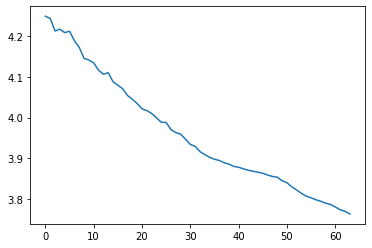

In [29]:
plt.plot(range(0, len(losses) ),losses)

### Saving model weights for Java

In [68]:
def save_model(model_name):
    directory = os.path.join(os.path.curdir, "models/%s-%s/"%(model_name, datetime.now().date()))
    if not os.path.exists(directory):
        os.makedirs(directory)
    i = 0
    for name, param in model.named_parameters():
        np.save(os.path.join(directory, str(i)), param.data.numpy())
        i+=1

In [1]:
dataset.data.x

NameError: name 'dataset' is not defined

In [69]:
save_model("GraphSage-CoraFull")

In [72]:
for name, param in model.named_parameters():
        print(name, param.data
             )

conv1.lin_l.weight tensor([[-0.0606, -0.2385, -0.0778,  ...,  0.1222,  0.0895, -0.0097],
        [-0.0367, -0.0140, -0.0205,  ...,  0.0379, -0.0228, -0.0191],
        [-0.0592, -0.0034,  0.0365,  ...,  0.0265,  0.0212, -0.0301],
        ...,
        [ 0.0026, -0.1265, -0.1162,  ...,  0.1333,  0.1493,  0.0242],
        [-0.0555,  0.0054, -0.0056,  ...,  0.1030, -0.0699, -0.0546],
        [ 0.1464, -0.0783, -0.0944,  ...,  0.0465,  0.0515,  0.2386]])
conv1.lin_r.weight tensor([[-0.0068, -0.0450, -0.0629,  ...,  0.1021,  0.1210,  0.0416],
        [-0.0438,  0.0249,  0.0014,  ...,  0.0209, -0.0314,  0.0092],
        [-0.0641, -0.0238, -0.0403,  ...,  0.0426,  0.0328, -0.0088],
        ...,
        [ 0.0830, -0.1683, -0.0705,  ...,  0.0725,  0.0336,  0.1589],
        [-0.0721,  0.0825, -0.0338,  ..., -0.0168, -0.0849, -0.0915],
        [ 0.2411,  0.1704, -0.0332,  ...,  0.0824, -0.0448,  0.1163]])
conv2.lin_l.weight tensor([[-6.1218e-02,  1.3760e-01,  1.1934e-01,  ...,  1.2790e-01,
        

### Saving Graph for Java

In [14]:
edges = pd.DataFrame(dataset.data.edge_index.numpy().T)
edges.to_csv("datasets/cora/edges", index = False, header=False)

In [11]:
vertices = pd.DataFrame({
"id": list(range(0, dataset.data.x.size()[0])),
"feature": dataset.data.x.numpy().tolist(),
"label" : dataset.data.y.numpy()
}).to_csv("datasets/cora/vertices", index = False, header = False)

In [21]:
labels = pd.DataFrame({
     "id": list(range(0, dataset.data.y.size()[0])),
    "label": dataset.data.y.numpy() 
})
labels.to_csv("datasets/cora/labels", index = False, header = False)